<center><h1>In the name of Allah</h1></center>

Name: Amir Mohammad Ezzati

Student Number: 402212269

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [1]:
!pip install torchattacks -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.9.0 requires requests>=2.27.1, but you have requests 2.25.1 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.25.1 which is incompatible.
tweepy 4.14.0 requires requests<3,>=2.27.0, but you have requests 2.25.1 which is incompatible.
yfinance 0.2.40 requires requests>=2.31, but yo

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torchattacks
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/DL/HW5/'

Mounted at /content/drive


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [6]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = CIFAR10(root="data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size, shuffle=False)
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:18<00:00, 9239754.02it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [7]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = resnet(len(classes)).to(device)

################################ End #########################################

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [ ]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################

def train_epoch(net, criterion, optimizer, dataloader):
    net.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    loss = running_loss / len(dataloader)
    accuracy = 100. * correct/total
    return loss, accuracy


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    print(f'Epoch [{epoch+1}/{epochs}] - '
          f'Train Loss: {train_loss:.4f} - '
          f'Train Accuracy: {train_acc:.4f}')

################################ End #########################################

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100] - Train Loss: 1.5406 - Train Accuracy: 45.0000
Epoch [2/100] - Train Loss: 1.1333 - Train Accuracy: 59.8380
Epoch [3/100] - Train Loss: 0.9448 - Train Accuracy: 66.7640
Epoch [4/100] - Train Loss: 0.7848 - Train Accuracy: 72.4120
Epoch [5/100] - Train Loss: 0.6608 - Train Accuracy: 76.6820
Epoch [6/100] - Train Loss: 0.5561 - Train Accuracy: 80.4480
Epoch [7/100] - Train Loss: 0.4597 - Train Accuracy: 83.8000
Epoch [8/100] - Train Loss: 0.3761 - Train Accuracy: 86.7540
Epoch [9/100] - Train Loss: 0.3069 - Train Accuracy: 89.2420
Epoch [10/100] - Train Loss: 0.2550 - Train Accuracy: 91.0200
Epoch [11/100] - Train Loss: 0.2161 - Train Accuracy: 92.3280
Epoch [12/100] - Train Loss: 0.1798 - Train Accuracy: 93.5400
Epoch [13/100] - Train Loss: 0.1421 - Train Accuracy: 94.8280
Epoch [14/100] - Train Loss: 0.1279 - Train Accuracy: 95.4180
Epoch [15/100] - Train Loss: 0.1013 - Train Accuracy: 96.4400
Epoch [16/100] - Train Loss: 0.0884 - Train Accuracy: 96.9180
Epoch [17/100] - 

In [ ]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################

def eval_epoch(net, criterion, dataloader):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    loss = running_loss / len(dataloader)
    accuracy = 100. * correct/total
    return loss, accuracy


test_loss, test_acc = eval_epoch(model, criterion, testloader)
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}')

################################ End #########################################

Test Loss: 2.2473 - Test Accuracy: 74.9100


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = data_path+ model_name
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [21]:
model = resnet(len(classes)).to(device)

model_path = data_path + "resnet18_cifar10_model_pretrained.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [19]:
def eval_attack(net, dataloader, attack):
    net.eval()
    correct = 0

    for image, target in tqdm(dataloader):
        # normal image
        image, target = image.to(device), target.to(device)
        image.requires_grad = True
        output = net(image)
        _, pred = output.max(1)

        # if the prediction of normal is wrong, skip this one
        if pred.item() != target.item():
            continue

        # attack
        eps_image = attack(image, target)
        output = net(eps_image)
        _, eps_pred = output.max(1)

        # check if the prediction is correct
        if eps_pred.item() == target.item():
            correct += 1

    acc = correct / len(dataloader)
    return acc

testloader_attack =  DataLoader(testset, batch_size=1)

In [9]:
from torchattacks.attacks.fgsm import FGSM

In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
from torchattacks.attacks.fgsm import FGSM

fgsm_1 = FGSM(model, eps=1/255)
acc = eval_attack(model, testloader_attack, fgsm_1)

print(f"\nTest Accuracy: {acc}")
################################ End #########################################

100%|██████████| 10000/10000 [01:54<00:00, 87.30it/s]


Test Accuracy: 0.531


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################

fgsm_2 = FGSM(model, eps=4/255)
acc = eval_attack(model, testloader_attack, fgsm_2)

print(f"\nTest Accuracy: {acc}")
################################ End #########################################

100%|██████████| 10000/10000 [01:56<00:00, 86.18it/s]


Test Accuracy: 0.2377


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################

fgsm_3 = FGSM(model, eps=8/255)
acc = eval_attack(model, testloader_attack, fgsm_3)

print(f"\nTest Accuracy: {acc}")
################################ End #########################################

100%|██████████| 10000/10000 [01:56<00:00, 86.02it/s]


Test Accuracy: 0.113


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [11]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):

        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()
        perturbed_image.to(device)

        if pred.item() == label.item():
            ##############################################################################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################

            for i in range(self.steps):
              perturbed_image = perturbed_image.clone().detach().requires_grad_(True)
              output = model(perturbed_image)

              # loss & update adversarial images
              loss = F.cross_entropy(output, label)
              grad = torch.autograd.grad(loss, perturbed_image, retain_graph=False, create_graph=False)[0]

              with torch.no_grad():
                perturbed_image = perturbed_image.detach() + self.alpha * grad.sign()
                delta = torch.clamp(perturbed_image - image, min=-self.epsilon, max=self.epsilon)
                adv_images = torch.clamp(image + delta, min=0, max=1).detach()

            ################################ End #########################################

        return perturbed_image

In [11]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################

for k in k_list:
  pgd = LinfPGDAttack(model, k=k)
  acc = eval_attack(model, testloader_attack, pgd)

  print(f"\nk={k} -------- Test Accuracy: {acc}")

################################ End #########################################

100%|██████████| 10000/10000 [03:00<00:00, 55.47it/s]



k=2 -------- Test Accuracy: 0.1646


100%|██████████| 10000/10000 [04:24<00:00, 37.79it/s]



k=4 -------- Test Accuracy: 0.0275


100%|██████████| 10000/10000 [07:19<00:00, 22.73it/s]


k=8 -------- Test Accuracy: 0.0011


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [ ]:
##############################################################################
# Implement the function described                                           #
##############################################################################

def random_visualize(model, data, attack, k=3):
  model.eval()
  indices = np.random.randint(0, len(data)-1, k)
  fig, axs = plt.subplots(k, 2, figsize=(4, 2*k))
  for k, i in enumerate(indices):
      image, target = data[i]
      image, target = image.unsqueeze(0).to(device), torch.tensor([target]).to(device)

      eps_image = attack(image, target)
      output = model(eps_image)
      _, eps_pred = output.max(1)

      axs[k][0].set_title(f"original: {classes[int(target)]}")
      axs[k][0].imshow(torch.permute(image.squeeze(), dims=(1,2,0)))

      axs[k][1].set_title(f"perturbed: {classes[int(eps_pred)]}")
      axs[k][1].imshow(torch.permute(eps_image.squeeze(), dims=(1,2,0)))

  for ax in axs.flat:
      ax.axis("off")

  plt.tight_layout()
  plt.show()

################################ End #########################################

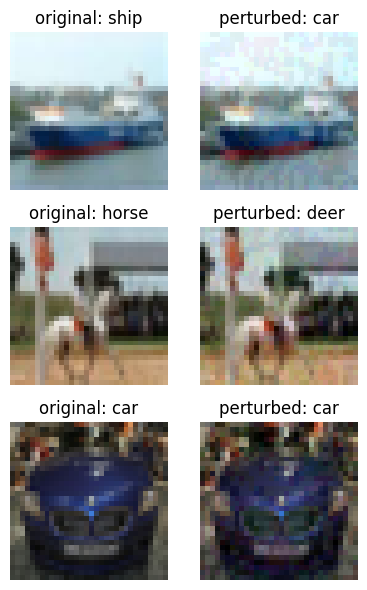

In [ ]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################
from torchattacks.attacks.fgsm import FGSM

fgsm = FGSM(model, eps=8/255)
random_visualize(model, testset, fgsm)

################################ End #########################################

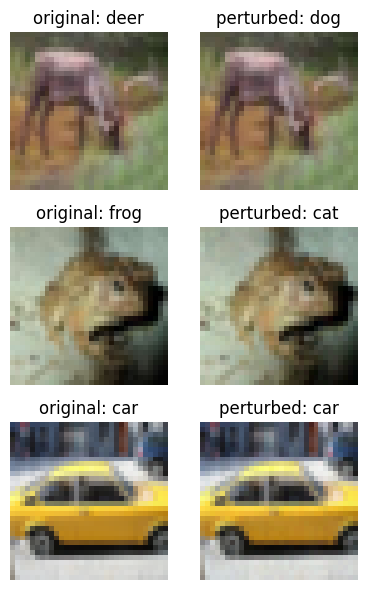

In [ ]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

pgd = LinfPGDAttack(model, k=4)
random_visualize(model, testset, pgd)

################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [ ]:
def train_epoch_adversarial(net, criterion, optimizer, dataloader, attack):
    net.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        eps_inputs = attack(inputs, targets)

        optimizer.zero_grad()

        outputs = net(eps_inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    loss = running_loss / len(dataloader)
    accuracy = 100. * correct/total
    return loss, accuracy

In [ ]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = resnet(len(classes)).to(device)
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100


fgsm = FGSM(adv_model, eps=8/255)
for epoch in range(epochs):
    train_loss, train_acc = train_epoch_adversarial(adv_model, criterion, optimizer, trainloader, fgsm)
    print(f'Epoch [{epoch+1}/{epochs}] - '
          f'Train Loss: {train_loss:.4f} - '
          f'Train Accuracy: {train_acc:.4f}')

################################ End #########################################

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100] - Train Loss: 2.1162 - Train Accuracy: 21.5820
Epoch [2/100] - Train Loss: 1.9923 - Train Accuracy: 25.3620
Epoch [3/100] - Train Loss: 1.9258 - Train Accuracy: 27.7300
Epoch [4/100] - Train Loss: 1.8780 - Train Accuracy: 29.2660
Epoch [5/100] - Train Loss: 1.8381 - Train Accuracy: 30.6480
Epoch [6/100] - Train Loss: 1.8069 - Train Accuracy: 31.5960
Epoch [7/100] - Train Loss: 1.7753 - Train Accuracy: 32.5200
Epoch [8/100] - Train Loss: 1.7393 - Train Accuracy: 33.7700
Epoch [9/100] - Train Loss: 1.7123 - Train Accuracy: 34.5220
Epoch [10/100] - Train Loss: 1.6770 - Train Accuracy: 35.6640
Epoch [11/100] - Train Loss: 1.6459 - Train Accuracy: 36.6560
Epoch [12/100] - Train Loss: 1.6048 - Train Accuracy: 37.7460
Epoch [13/100] - Train Loss: 1.5714 - Train Accuracy: 38.6920
Epoch [14/100] - Train Loss: 1.5392 - Train Accuracy: 39.5620
Epoch [15/100] - Train Loss: 1.4993 - Train Accuracy: 40.6620
Epoch [16/100] - Train Loss: 1.4607 - Train Accuracy: 41.9640
Epoch [17/100] - 

In [ ]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

test_loss, test_acc = eval_epoch(adv_model, criterion, testloader)
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}')

################################ End #########################################

Test Loss: 2.4909 - Test Accuracy: 60.7800


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

fgsm = FGSM(adv_model, eps=8/255)
acc = eval_attack(adv_model, testloader_attack, fgsm)

print(f"\nTest Accuracy: {acc}")
################################ End #########################################

100%|██████████| 10000/10000 [01:42<00:00, 97.93it/s] 


Test Accuracy: 0.2395


In [ ]:
# Save model
adv_model.eval()
model_name = "resnet18_adv.pth"
model_PATH = data_path + model_name
torch.save(adv_model.state_dict(), model_PATH)

In [24]:
adv_model = resnet(len(classes)).to(device)

model_path = data_path + "resnet18_adv.pth"
adv_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [25]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

k=4
pgd = LinfPGDAttack(adv_model, k=k)
acc = eval_attack(adv_model, testloader_attack, pgd)

print(f"\nk={k} -------- Test Accuracy: {acc}")


################################ End #########################################

100%|██████████| 10000/10000 [04:00<00:00, 41.61it/s]


k=4 -------- Test Accuracy: 0.572


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?      

Adversarially trained models often exhibit slightly lower accuracy on non-perturbed images compared to models trained without adversarial images. This reduction in accuracy is due to the regularization effect of adversarial training, which prioritizes robustness and occasionally compromises performance on non-perturbed data.     

Adversarially trained models typically achieve higher accuracy on adversarial images, especially those crafted using the same method employed during training. This is because the adversarial training process equips the model with the ability to resist specific types of adversarial perturbations.           

- What do you conclude from the result of the FGSM attack on the adversarially trained model?       

adversarially trained model demonstrates better accuracy on FGSM-generated adversarial examples compared to a normal model, it signifies that the adversarial training has effectively increased the model's resistance to this type of attack.        

- What do you conclude from the result of the PGD attack on the adversarially trained model?       

Similar to the FGSM results, this indicates that adversarial training has effectively boosted the model's robustness against PGD attack. However, because PGD introduces less noise than FGSM, the increase in accuracy on PGD attack was greater than the increase observed on FGSM attack.      

- What is you final conclusion?        

Adversarial training enhances a model's robustness against specific adversarial attacks at the cost of slightly reduced accuracy on non-perturbed images. This trade-off is evident as adversarially trained models show higher accuracy on adversarial examples, particularly those generated by methods used during training, such as FGSM and PGD. The improved performance against FGSM and PGD attacks highlights the effectiveness of adversarial training in fortifying the model against these perturbations. Notably, the model's increased accuracy on PGD examples, which involve less noise than FGSM, further underscores the success of adversarial training in enhancing robustness. Overall, while adversarial training may slightly compromise performance on clean data, it significantly strengthens the model's defense against adversarial attacks, making it a valuable approach for improving model security and reliability.